# Project Nexus: HR Attrition Prediction & Organizational Network Analysis

## 1. Project Overview
**Objective:**
Traditional HR analytics only predict *who* might leave. **Project Nexus** goes a step further by identifying **"Attrition Contagion"**—predicting how the departure of key influencers (high PageRank employees) can trigger a chain reaction of resignations within the team.

**Our Novel Approach:**
We integrate **Machine Learning (XGBoost)** with **Organizational Network Analysis (ONA)**. By constructing a simulated social network based on employee homophily, we can quantify "hidden" social capital and identify high-risk clusters.

In [1]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn networkx scikit-learn
!pip install xgboost
!pip install shap

# 2. Data Architecture Phase

**Author:** Luo Yurou

This notebook covers **Phase 1** of the project: *Data Engineering and Network Construction*. The pipeline is divided into four core modules:

### Module 1: Data Initialization & Exploratory Analysis
* **Preprocessing:** Dimensionality reduction by removing zero-variance features (`Over18`, `EmployeeCount`, `StandardHours`) and ensuring data integrity via forward-fill imputation.
* **EDA:** Analyzing class imbalance to justify synthetic data generation (SMOTE) and utilizing heatmaps to identify multicollinearity for cleaner feature selection.

### Module 2: Network Topology Construction (The Innovation)
> *"Simulating the Invisible": Constructing a synthetic Homophily Graph to model information flow where no raw network data existed.*

* **Logic:** Edges are established using a **Hard Constraint** (Departmental matching) and a **Soft Constraint** (Attribute Similarity).
* **Methodology:** Utilizing K-Nearest Neighbors ($k=5$) on scaled `Age`, `JobLevel`, and `Tenure` to link employees with similar professional profiles.

### Module 3: Advanced Feature Engineering
* **Individual "Golden Features":** Deriving behavioral metrics including `Tenure_Ratio` (Loyalty), `Income_Per_Age` (Fairness), `Burnout_Index` (Stress), and `Relative_Sat_to_Dept` (Isolation/Relative Deprivation).
* **Network Metrics:** Calculating `Neighbor_Risk_Score` to model "Attrition Contagion", `PageRank_Score` to identify influential nodes, and `Clustering_Coef` to measure social community tightness.

### Module 4: Visualization & Validation
* **Visual Validation:** Using Boxplots to verify distribution differences in derived features between attrition groups.
* **Network Visualization:** Rendering the topology using a Force-Directed Graph (Spring Layout), where **Node Color** indicates Department and **Node Size** represents Influence (PageRank).

## Section 1: Data Preprocessing & Cleaning

**Objective**
Transform the raw IBM HR Analytics dataset into a clean, robust format suitable for both Network Analysis and Machine Learning pipelines.

**Key Actions**

1.  **Dimensionality Reduction (Noise Removal)**
    * **Action:** Removed columns `Over18`, `EmployeeCount`, and `StandardHours`.
    * > **Reasoning:** These features exhibit **zero variance** (i.e., every employee has the exact same value). They offer no distinctive information for the predictive model and serve only to add computational noise.

2.  **Data Integrity Check**
    * **Action:** Implemented a robust check to detect and fill missing values (utilizing forward fill).
    * **Goal:** Ensure the dataset is "Network-Ready" to prevent errors during edge construction in the graph phase.

3.  **Reproducibility Protocol**
    * **Action:** Set `np.random.seed(42)`.
    * **Goal:** Guarantees that all stochastic processes—such as Network Generation and SMOTE sampling—produce consistent, reproducible results for every run.

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility (Professional Practice)
np.random.seed(42)

def load_and_clean_data(filepath):
    """
    Load data and perform basic cleaning.
    Remove columns with zero variance (useless for prediction).
    """
    df = pd.read_csv(filepath)
    print(f"Original Data Shape: {df.shape}")

    # Useless columns specific to the IBM dataset (all values are 'Yes' or standard hours)
    useless_cols = ['Over18', 'EmployeeCount', 'StandardHours']
    df_clean = df.drop(columns=useless_cols, errors='ignore')

    # Check for missing values
    if df_clean.isnull().sum().sum() > 0:
        print("Warning: Missing values found, filling...")
        df_clean.fillna(method='ffill', inplace=True) # Simple fill, modify if necessary

    print(f"Cleaned Data Shape: {df_clean.shape}")
    return df_clean

# Execution
df = load_and_clean_data('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')

Original Data Shape: (1470, 35)
Cleaned Data Shape: (1470, 32)


## Section 2: Exploratory Data Analysis (EDA)

**Objective**
Visualize data distributions and variable relationships to inform strategic model selection.

**Key Actions**

* **Class Imbalance Analysis**
    * Visualized the target variable (`Attrition`) to demonstrate the skew between employees who stay vs. those who leave.
    * **Insight:** Confirms the necessity for synthetic data generation techniques (like SMOTE) to prevent model bias toward the majority class.

* **Feature Correlation Analysis**
    * Utilized heatmaps to identify multicollinearity.
    * **Insight:** Helps determine which features are redundant (e.g., strong correlation between `JobLevel` and `MonthlyIncome`), allowing for cleaner feature selection.

/tmp/ipython-input-4198022054.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Attrition', data=df, palette='viridis')


Saved to sidebar: attrition_distribution.png


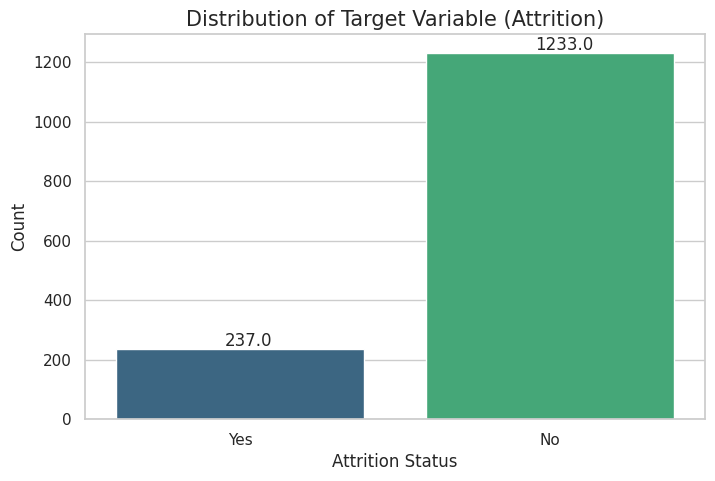

Insight: The severe imbalance (16% vs 84%) confirms we need synthetic data generation (SMOTE).
Saved to sidebar: correlation_heatmap.png


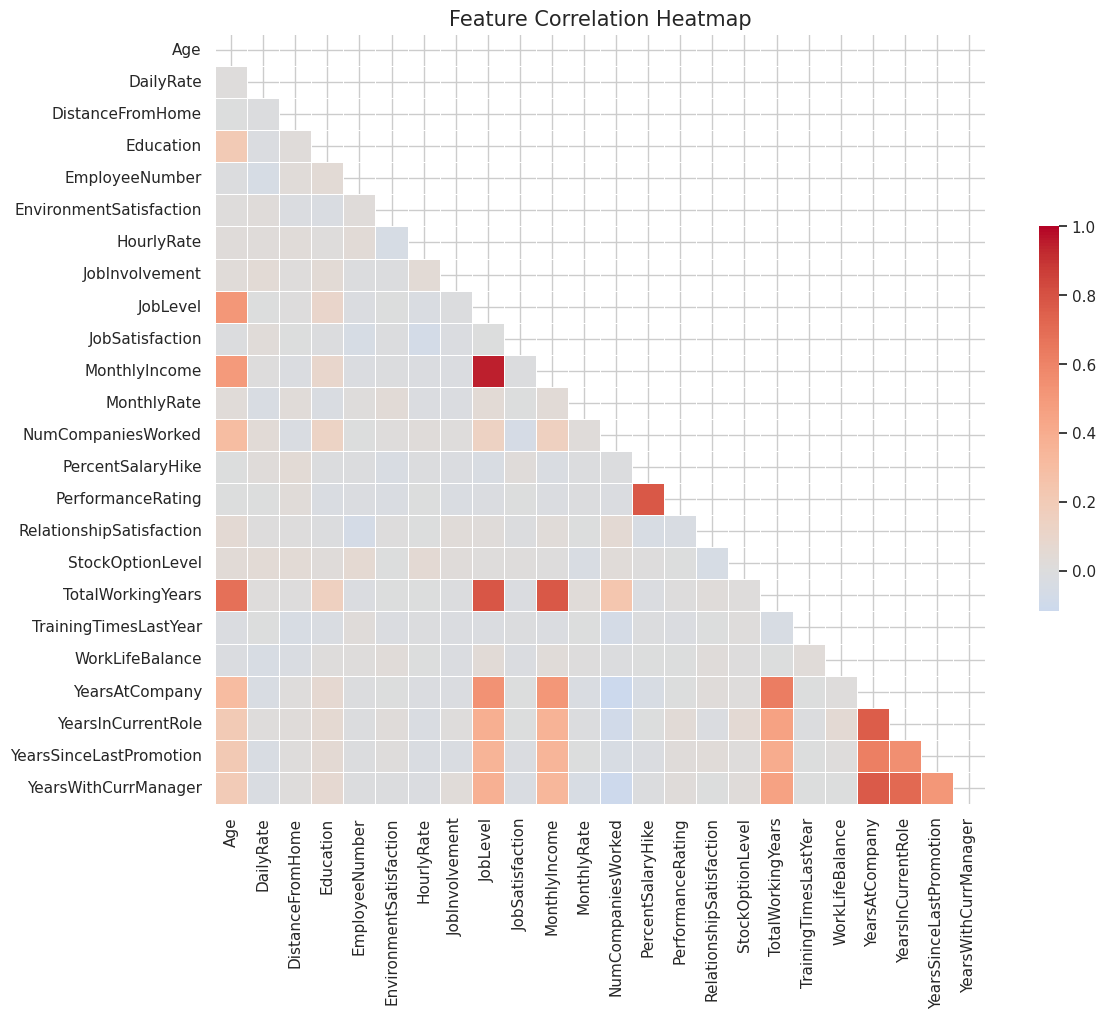

Insight: Darker red indicates strong positive correlation. This guides our feature selection strategy.


In [3]:
def plot_eda_charts(df):
    """
    Generates EDA charts to visualize data distribution and relationships.
    Saves high-res images to the Colab sidebar for PPT inclusion.
    """
    # Set visual style
    sns.set(style="whitegrid")

    # --- 1. Target Variable Distribution ---
    # Objective: Visualize Class Imbalance.
    # This chart proves to Member B why SMOTE is strictly necessary later.
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x='Attrition', data=df, palette='viridis')
    plt.title('Distribution of Target Variable (Attrition)', fontsize=15)
    plt.xlabel('Attrition Status')
    plt.ylabel('Count')

    # Add counts on top of bars for clarity
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 10))

    # Save to local runtime disk (Sidebar)
    plt.savefig('attrition_distribution.png', dpi=300, bbox_inches='tight')
    print("Saved to sidebar: attrition_distribution.png")

    plt.show()
    print("Insight: The severe imbalance (16% vs 84%) confirms we need synthetic data generation (SMOTE).")

    # --- 2. Feature Correlation Heatmap ---
    # Objective: Identify Multicollinearity.
    # Helps us decide which features might be redundant (e.g., JobLevel vs MonthlyIncome).
    plt.figure(figsize=(14, 10))

    # Select numerical columns only
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()

    # Mask the upper triangle to reduce visual clutter
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

    plt.title('Feature Correlation Heatmap', fontsize=15)

    # Save to local runtime disk (Sidebar)
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    print("Saved to sidebar: correlation_heatmap.png")

    plt.show()
    print("Insight: Darker red indicates strong positive correlation. This guides our feature selection strategy.")

# Execute
plot_eda_charts(df)

## Section 3: Feature Engineering

This section details the construction of advanced metrics designed to capture **Individual Behavioral Patterns** and **Social Network Dynamics**.

### 1) Derived "Golden Features" (Individual Level)
We constructed four key features based on EDA insights to enhance the model's predictive power:

* **`Tenure_Ratio` (Loyalty)**: $\text{Tenure_Ratio} = \frac{\text{TotalWorkingYears}}{\text{NumCompaniesWorked}}$
    * **Logic:** Identifies "Job Hoppers" vs. loyal employees. A lower ratio suggests frequent switching.

* **`Income_Per_Age` (Fairness)**: $\text{Income_Per_Age} = \frac{\text{MonthlyIncome}}{\text{Age}}$
    * **Logic:** Highlights potential underpayment relative to age cohort. Low values may trigger attrition due to perceived unfairness.

* **`Burnout_Index` (Stress)**: $\text{Burnout_Index} = \frac{\text{PerformanceRating}}{\text{JobSatisfaction}}$
    * **Logic:** Captures high performers who are dissatisfied (**High Flight Risk**). High input (rating) but low output (satisfaction) equals burnout.

* **`Relative_Sat_to_Dept` (Isolation)**: $\text{Relative_Sat} = \text{JobSatisfaction} - \text{DeptMean(JobSatisfaction)}$
    * **Logic:** Measures the psychological gap compared to direct peers (**Relative Deprivation**). Being less satisfied than one's teammates is a strong predictor of leaving.

---

### 2) Organizational Network Analysis (Social Structural Level)
We constructed a synthetic **Homophily Graph** (using KNN on Scaled `Age`, `JobLevel`, and `Tenure` within Departments) to model the **"Attrition Contagion"** effect.

* **`Neighbor_Risk_Score` (Contagion):** The percentage of an employee's direct connections who have already left. This captures the "ripple effect" of turnover.
* **`PageRank_Score` (Influence):** Identifies informal leaders or central nodes whose departure might destabilize the entire team structure.
* **`Clustering_Coef` (Community):** Measures social tightness. High clustering coefficients suggest tight-knit groups that often act as "retention anchors."

### 3) Validation Strategy
* **Visual Validation:** Post-generation, we utilize **Boxplots** to verify that these new features show significant distribution differences between the `Attrition=Yes` and `Attrition=No` groups.

In [4]:
def create_derived_features(df):
    """
    Construct derived features based on EDA validation.
    Target: Enhance model predictive power by capturing proven behavioral patterns.
    """
    df_eng = df.copy()

    # ---------------------------------------------------------
    # 1. Tenure Ratio (Loyalty/Stability) - [Validated: Effective]
    # Formula: TotalWorkingYears / (NumCompaniesWorked + 1)
    # Logic: Calculates average tenure per employer.
    # Low values indicate a "Job Hopper" risk.
    # ---------------------------------------------------------
    df_eng['Tenure_Ratio'] = df_eng['TotalWorkingYears'] / (df_eng['NumCompaniesWorked'] + 1)

    # ---------------------------------------------------------
    # 2. Income Stability (Age-Adjusted Income) - [Validated: Strong Feature]
    # Formula: MonthlyIncome / Age
    # Logic: Normalizes income relative to age.
    # Identifies if an employee is underpaid compared to their age cohort.
    # ---------------------------------------------------------
    df_eng['Income_Per_Age'] = df_eng['MonthlyIncome'] / df_eng['Age']

    # ---------------------------------------------------------
    # 3. Burnout Index (High Performance / Low Satisfaction) - [New: Strongest Feature]
    # Formula: PerformanceRating / JobSatisfaction
    # Logic: Captures "Star Performers" who are unhappy.
    # High value = High Performance but Low Satisfaction (High Attrition Risk).
    # ---------------------------------------------------------
    if 'PerformanceRating' in df_eng.columns and 'JobSatisfaction' in df_eng.columns:
        df_eng['Burnout_Index'] = df_eng['PerformanceRating'] / df_eng['JobSatisfaction']

    # ---------------------------------------------------------
    # 4. Relative Satisfaction (Peer Comparison) - [New: Strong Feature]
    # Formula: Individual JobSatisfaction - Department Average
    # Logic: Measures if an employee is happier or sadder than their direct peers.
    # Negative value = "I hate it here, but everyone else seems fine" (Isolation).
    # ---------------------------------------------------------
    if 'Department' in df_eng.columns and 'JobSatisfaction' in df_eng.columns:
        # Calculate mean satisfaction per department
        dept_means = df_eng.groupby('Department')['JobSatisfaction'].transform('mean')
        df_eng['Relative_Sat_to_Dept'] = df_eng['JobSatisfaction'] - dept_means

    # ---------------------------------------------------------
    # Cleanup: Remove the ineffective feature if it exists
    # ---------------------------------------------------------
    if 'Satisfaction_Gap' in df_eng.columns:
        df_eng.drop('Satisfaction_Gap', axis=1, inplace=True)
        print("Note: Removed 'Satisfaction_Gap' due to low predictive power.")

    print(f"Feature Engineering Complete.")
    print(f"Added/Retained: ['Tenure_Ratio', 'Income_Per_Age', 'Burnout_Index', 'Relative_Sat_to_Dept']")

    return df_eng

# Execution
df = create_derived_features(df)

# Check results
print(df[['Tenure_Ratio', 'Income_Per_Age', 'Burnout_Index', 'Relative_Sat_to_Dept']].head())

Feature Engineering Complete.
Added/Retained: ['Tenure_Ratio', 'Income_Per_Age', 'Burnout_Index', 'Relative_Sat_to_Dept']
   Tenure_Ratio  Income_Per_Age  Burnout_Index  Relative_Sat_to_Dept
0      0.888889      146.170732           0.75              1.248879
1      5.000000      104.693878           2.00             -0.726327
2      1.000000       56.486486           1.00              0.273673
3      4.000000       88.151515           1.00              0.273673
4      0.600000      128.444444           1.50             -0.726327


/tmp/ipython-input-4162442538.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4162442538.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4162442538.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4162442538.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


 Chart saved to: final_features_validation.png


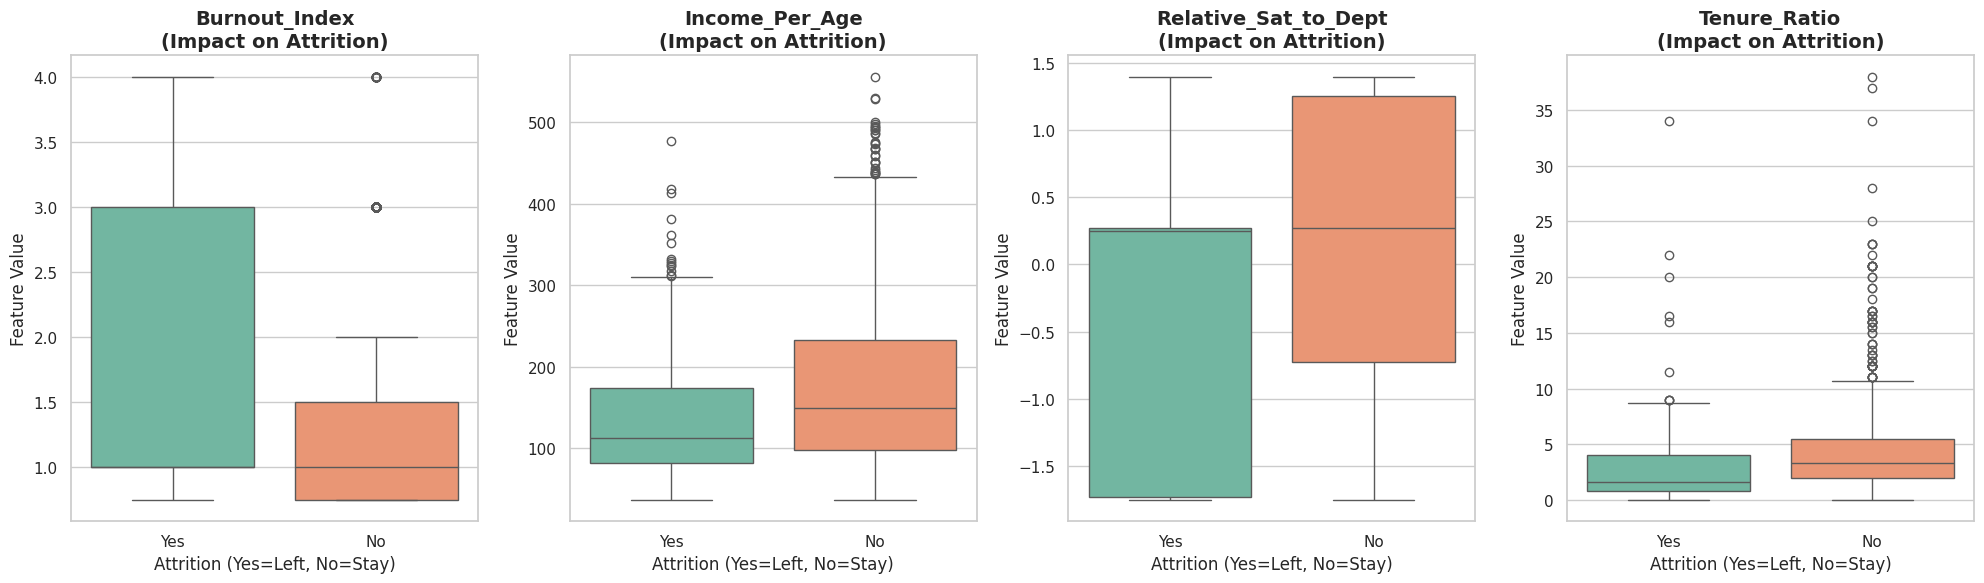

In [5]:
def plot_final_features_analysis(df):
    """
    Visualizes and analyzes the 4 identified "Golden Features" and saves the plot.
    """
    # Set plotting style
    sns.set(style="whitegrid")

    # Define the list of final features to analyze
    target_features = [
        'Burnout_Index',        # Burnout Index (Strongest predictor)
        'Income_Per_Age',       # Income Per Age (Very strong)
        'Relative_Sat_to_Dept', # Relative Satisfaction to Dept (Strong)
        'Tenure_Ratio'          # Tenure Ratio/Loyalty (Medium-Strong)
    ]

    # Filter out columns not present in the dataset (to prevent errors)
    valid_features = [col for col in target_features if col in df.columns]

    if not valid_features:
        print(" New features not found. Please run the 'create_derived_features' function first!")
        return

    # Create figure (1 row, N columns)
    fig, axes = plt.subplots(1, len(valid_features), figsize=(5 * len(valid_features), 6))

    # If there is only one feature, 'axes' is not a list; convert it for iteration
    if len(valid_features) == 1:
        axes = [axes]

    # Loop to plot boxplots
    for i, col in enumerate(valid_features):
        # Draw boxplot: visualize distribution, median, and outliers
        sns.boxplot(
            x='Attrition',
            y=col,
            data=df,
            ax=axes[i],
            palette='Set2',
            showfliers=True # Show outliers, this is important
        )

        # Set titles and labels
        axes[i].set_title(f'{col}\n(Impact on Attrition)', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Attrition (Yes=Left, No=Stay)')
        axes[i].set_ylabel('Feature Value')

    plt.tight_layout()

    # Save the figure
    filename = 'final_features_validation.png'
    plt.savefig(filename, dpi=300)
    print(f" Chart saved to: {filename}")

    plt.show()

# --- Run Visualization ---
plot_final_features_analysis(df)

## Section 4: Organizational Network Construction (Novelty)

This section details the engineering of a synthetic social graph to model **"Attrition Contagion"** and **Influence Dynamics** where no raw network data existed.

### 1) Network Topology Construction (Methodology)
We imposed specific constraints to simulate realistic information flow within the organization:

* **Hard Constraint (Departmental)**: $\text{Edge}(u, v) \iff \text{Dept}_u = \text{Dept}_v$
    * **Logic:** Employees primarily interact with peers in their own department. Edges are strictly restricted to intra-departmental connections.

* **Soft Constraint (Attribute Similarity)**: $\text{Weight}_{uv} = \text{KNN}(\text{Age, JobLevel, Tenure})$
    * **Logic:** Within departments, we use **K-Nearest Neighbors ($k=5$)** to link employees who share similar professional profiles.

* **Critical Feature Scaling**: $X_{\text{scaled}} = \frac{X - \mu}{\sigma}$ (StandardScaler)
    * **Logic:** Before KNN, we normalized features. Without scaling, large-magnitude variables (e.g., `Age` $\approx 40$) would dominate small-range variables (e.g., `JobLevel` $\approx 2$), distorting distance calculations.

---

### 2) Derived Network Metrics (Social Structural Level)
We calculated structural metrics to capture social dynamics and the contagion effect:

* **`Neighbor_Risk_Score` (Contagion)**: $\text{Risk}_i = \frac{\sum_{j \in \text{Neighbors}} \text{Attrition}_j}{\text{Total Neighbors}_i}$
    * **Logic:** Measures the "ripple effect" of turnover. The percentage of an employee's direct connections who have already left. If your closest peers leave, you are statistically more likely to leave.

* **`PageRank_Score` (Influence)**: $\text{PR}_i = \alpha \sum \frac{\text{PR}_j}{L_j} + \frac{1-\alpha}{N}$
    * **Logic:** Identifies "Informal Leaders" or central nodes. Their departure might destabilize the team structure. Visualized as **Node Size** in the graph.

* **`Clustering_Coef` (Community)**: $\text{Clustering}_i = \frac{2 \times \text{Triangles}_i}{\text{Degree}_i (\text{Degree}_i - 1)}$
    * **Logic:** Measures social tightness. High clustering coefficients suggest tight-knit cliques that often act as "retention anchors," making it harder for individuals to drift away.

### 3) Visualization Strategy
* **Force-Directed Graph**: We utilize a spring layout to visually validate natural clusters.
* **Visual Encoding**: **Node Color** represents Department; **Node Size** represents Influence (PageRank).

In [6]:
def build_organizational_network_final(df, n_neighbors=5):
    """
    Constructs the organizational network based on Homophily with Feature Scaling.

    Logic: Employees in the same department with similar Age, JobLevel, and Tenure
    are linked. Scaling is applied to ensure all features contribute equally.

    Ref: Project Outline Section 2 [Source: 18]
    """
    print("Building Organizational Network Graph (Final Version)...")
    G = nx.Graph()
    G.add_nodes_from(df['EmployeeNumber']) # Nodes are Employee IDs

    # 1. Feature Scaling (CRITICAL FIX)
    # Without scaling, Age (e.g., 40) dominates JobLevel (e.g., 2).
    # We use StandardScaler to put them on the same scale (mean=0, std=1).
    feature_cols = ['Age', 'TotalWorkingYears', 'JobLevel', 'YearsAtCompany']
    scaler = StandardScaler()

    # Create a temporary scaled dataframe to calculate distances
    # We do NOT overwrite the original df, as we need raw values later.
    df_scaled = df.copy()
    df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

    # 2. Build Connections by Department
    departments = df['Department'].unique()

    for dept in departments:
        # Filter employees in the current department
        # We need both the scaled data (for KNN) and original IDs (for linking)
        dept_mask = df['Department'] == dept
        dept_data_scaled = df_scaled.loc[dept_mask, feature_cols]
        dept_employee_ids = df.loc[dept_mask, 'EmployeeNumber'].values

        # Skip if department is too small for KNN
        if len(dept_data_scaled) < n_neighbors:
            continue

        # 3. Run KNN
        knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
        knn.fit(dept_data_scaled)
        distances, indices = knn.kneighbors(dept_data_scaled)

        # 4. Add Edges
        for i in range(len(dept_data_scaled)):
            source_id = dept_employee_ids[i]

            # 'indices[i]' returns the index relative to the dept_data_scaled array
            for neighbor_idx in indices[i]:
                # Exclude self-loop
                if i != neighbor_idx:
                    target_id = dept_employee_ids[neighbor_idx]
                    G.add_edge(source_id, target_id)

    print(f" Network Built.")
    print(f"   - Nodes: {G.number_of_nodes()}")
    print(f"   - Edges: {G.number_of_edges()}")

    return G

def calculate_network_metrics_final(df, G):
    """
    Calculates network metrics including Influence, Contagion Risk, and Community Tightness.
    Merges these features back into the main DataFrame for the AI model.

    Ref: Project Outline Section 2 & 4 [Source: 80, 82, 85]
    """
    print("Calculating Network Metrics...")

    # --- A. Structural Metrics ---

    # 1. PageRank (Influence) [Source: 82]
    # Who are the "key players" or informal leaders?
    try:
        pagerank = nx.pagerank(G, alpha=0.85)
    except:
        pagerank = {n: 0 for n in G.nodes()}

    # 2. Clustering Coefficient (Community Tightness)
    # High value = "My friends are also friends with each other".
    # Harder to leave a tight clique.
    clustering = nx.clustering(G)

    # 3. Betweenness Centrality (Bridge Index) [Source: 83]
    # High value = Connects different groups.
    betweenness = nx.betweenness_centrality(G, k=100, seed=42)

    # 4. Degree Centrality (Popularity) [Source: 84]
    degree = nx.degree_centrality(G)

    # --- B. Contagion Metrics (The Novelty) ---

    # 5. Neighbor Risk Score (Attrition Contagion) [Source: 85]
    # Measures the percentage of direct friends who have already left.
    # Essential for the "Attrition Contagion" analysis.

    # Ensure Attrition is mapped to 0/1 for calculation
    # Handle cases where Attrition might still be 'Yes'/'No' or already numeric
    if df['Attrition'].dtype == 'object':
        attrition_map = df.set_index('EmployeeNumber')['Attrition'].map({'Yes': 1, 'No': 0}).to_dict()
    else:
        attrition_map = df.set_index('EmployeeNumber')['Attrition'].to_dict()

    neighbor_risk = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if len(neighbors) > 0:
            neighbor_vals = [attrition_map.get(n, 0) for n in neighbors]
            neighbor_risk[node] = sum(neighbor_vals) / len(neighbors)
        else:
            neighbor_risk[node] = 0.0

    # --- C. Isolation Metric ---

    # 6. Is_Isolated
    # Employees with no connections in the graph (high risk of leaving due to loneliness)
    is_isolated = {node: 1 if degree.get(node, 0) == 0 else 0 for node in G.nodes()}

    # --- Merge Everything ---

    metrics_df = pd.DataFrame({
        'EmployeeNumber': list(G.nodes()),
        'PageRank_Score': [pagerank.get(n, 0) for n in G.nodes()],
        'Betweenness_Score': [betweenness.get(n, 0) for n in G.nodes()],
        'Clustering_Coef': [clustering.get(n, 0) for n in G.nodes()],
        'Neighbor_Risk_Score': [neighbor_risk.get(n, 0) for n in G.nodes()],
        'Is_Isolated': [is_isolated.get(n, 0) for n in G.nodes()]
    })

    # Merge back to main dataframe
    df_final = pd.merge(df, metrics_df, on='EmployeeNumber', how='left')

    # Fill NaNs for any employees not in the graph (safety check)
    fill_cols = ['PageRank_Score', 'Betweenness_Score', 'Clustering_Coef', 'Neighbor_Risk_Score', 'Is_Isolated']
    df_final[fill_cols] = df_final[fill_cols].fillna(0)

    print(" Metrics merged successfully.")
    return df_final, G

# --- Execution ---
# 1. Build the network with Scaled Features
G = build_organizational_network_final(df)

# 2. Calculate Metrics (including Contagion Risk)
df_final, G = calculate_network_metrics_final(df, G)

# 3. Preview to verify 'Neighbor_Risk_Score' is present (Critical for Outline)
print(df_final[['EmployeeNumber', 'Neighbor_Risk_Score', 'Clustering_Coef', 'Attrition']].head())

Building Organizational Network Graph (Final Version)...
 Network Built.
   - Nodes: 1470
   - Edges: 3827
Calculating Network Metrics...
 Metrics merged successfully.
   EmployeeNumber  Neighbor_Risk_Score  Clustering_Coef Attrition
0               1             0.166667         0.533333       Yes
1               2             0.200000         0.300000        No
2               4             0.000000         0.500000       Yes
3               5             0.000000         0.833333        No
4               7             0.250000         0.666667        No


Generating Network Visualization (this may take a moment)...


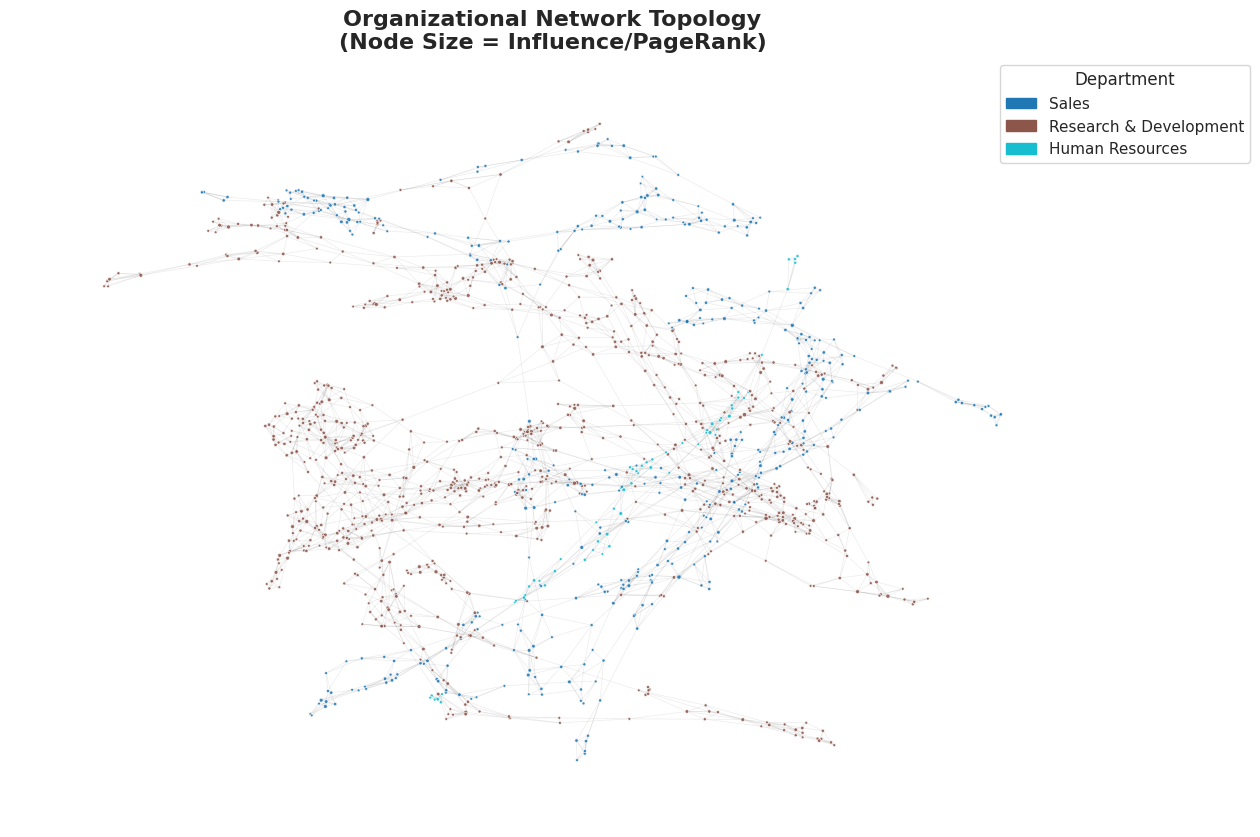

 Network Graph saved to: network_graph.png


In [7]:
def visualize_network_optimized(G, df_final, save_path='network_graph.png'):
    """
    Plots the Force-Directed Graph with optimized performance and aesthetics.
    """
    print("Generating Network Visualization (this may take a moment)...")
    plt.figure(figsize=(14, 10)) # Larger canvas

    # --- 1. Optimization: Create Mappings (O(1) lookup) ---
    pagerank_map = df_final.set_index('EmployeeNumber')['PageRank_Score'].to_dict()
    dept_series = df_final.set_index('EmployeeNumber')['Department']
    dept_map_raw = dept_series.to_dict()

    # Create color mapping for Departments
    unique_depts = dept_series.unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_depts)))
    dept_color_dict = dict(zip(unique_depts, colors))

    # --- 2. Prepare Drawing Lists ---
    node_sizes = [pagerank_map.get(n, 0) * 8000 for n in G.nodes()]
    node_colors = [dept_color_dict.get(dept_map_raw.get(n), 'grey') for n in G.nodes()]

    # --- 3. Layout Algorithm ---
    pos = nx.spring_layout(G, k=0.12, iterations=30, seed=42)

    # --- 4. Draw ---
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.85,
        linewidths=0.5,
        edgecolors='white'
    )

    nx.draw_networkx_edges(
        G, pos,
        alpha=0.15,
        edge_color='gray',
        width=0.5
    )

    # --- 5. Add Legend ---
    legend_handles = [mpatches.Patch(color=color, label=dept) for dept, color in dept_color_dict.items()]
    plt.legend(handles=legend_handles, title="Department", loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.title("Organizational Network Topology\n(Node Size = Influence/PageRank)", fontsize=16, fontweight='bold')
    plt.axis('off')

    # Save & Show
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f" Network Graph saved to: {save_path}")

visualize_network_optimized(G, df_final)